In [1]:
import numpy as np
import qiskit.pulse as pulse
import qiskit.pulse.library as pulse_lib
from qiskit.compiler import assemble
from qiskit.pulse.library import Waveform
from qiskit.tools.monitor import job_monitor
from qiskit.pulse import library
from qiskit.test.mock import FakeArmonk
from qiskit.providers.aer import PulseSimulator
backend = FakeArmonk()

# sample duration for pulse instructions 
#dt = 1e-9# create the model
backend_config = backend.configuration()
backend_defaults = backend.defaults()
dt = backend_config.dt
#duffing_model = helper.get_transmon(dt)# get qubit frequency from Duffing model
#qubit_lo_freq = duffing_model.hamiltonian.get_qubit_lo_from_drift()

assert backend_config.open_pulse, "Backend doesn't support Pulse"

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

qubit = 0 # qubit we will analyze
default_qubit_freq = backend_defaults.qubit_freq_est[qubit] # Default qubit frequency in Hz. 
print(f"Qubit {qubit} has an estimated frequency of {default_qubit_freq/ GHz} GHz.")

# scale data (specific to each device)
scale_factor = 1e-14

# number of shots for our experiments
NUM_SHOTS = 1024

### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

Qubit 0 has an estimated frequency of 4.971852852405576 GHz.


In [2]:
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data. 
    """
    job_results = job.result() # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(job_results.get_memory(i)[qubit]*scale_factor) 
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit]*scale_factor)  
    return result_data

def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require 
    durations which are multiples of 16 samples.
    """
    return (int(num) - (int(num)%16))

# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt

# Find out which measurement map index is needed for this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

# Get default measurement pulse from instruction schedule map
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

cal_qubit_freq = default_qubit_freq

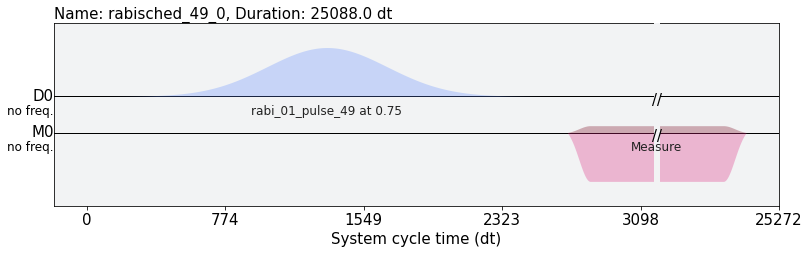

In [15]:

# experimental configuration
num_rabi_points = 50 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

# Create schedule
rabi_01_schedules = []
# loop over all drive amplitudes
for ii, drive_amp in enumerate(drive_amps):
    # drive pulse
    rabi_01_pulse = pulse_lib.gaussian(duration=drive_samples, 
                                       amp=drive_amp, 
                                       sigma=drive_sigma, 
                                       name=f'rabi_01_pulse_%d at {drive_amp}' % ii)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='rabisched_%d_0' % ii)
    schedule |= pulse.Play(rabi_01_pulse, drive_chan)
    schedule |= measure << schedule.duration # shift measurement to after drive pulse
    rabi_01_schedules.append(schedule)
    
# Draw rabi schedule
rabi_01_schedules[-1].exclude(channels=acq_chan).draw()

In [4]:
# Assemble the schedules into a program
# Note: We drive at the calibrated frequency.
rabi_01_expt_program = assemble(rabi_01_schedules,
                                backend=backend,
                                meas_level=1,
                                meas_return='avg',
                                shots=NUM_SHOTS,
                                schedule_los=[{drive_chan: cal_qubit_freq}]
                                               * num_rabi_points)

rabi_01_job = backend.run(rabi_01_expt_program)
rabi_01_data = get_job_data(rabi_01_job, average=True)

/home/doki/miniconda3/envs/myqis/lib/python3.8/site-packages/qiskit/providers/aer/pulse/system_models/string_model_parser/string_model_parser.py:280: DeprecationWarning: Using the `__mul__` operator `A * B` as shorthand for `A.dot(B)` is deprecated as of version 0.17.0 and will be  removed no earlier than 3 months after the release date. As an alternative, use the compose operator `B & A` in place of `A * B` as a replacement.
  stack.append(op1 * op2)
/home/doki/miniconda3/envs/myqis/lib/python3.8/site-packages/qiskit/test/mock/fake_backend.py:127: DeprecationWarning: Passing `system_model` as a positional argument to `PulseSimulator.run` has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Pass `system_model` as a kwarg `system_model=model` instead.
  job = sim.run(qobj, system_model)
/home/doki/miniconda3/envs/myqis/lib/python3.8/site-packages/qiskit/providers/aer/pulse/system_models/string_model_parser/operator_generators.py

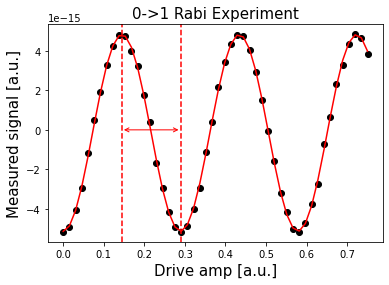

Pi amplitude (0->1) is 0.145


In [5]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.signal import find_peaks

def fit_function(x_values, y_values, function, init_params):
    """Fit a function using scipy curve_fit."""
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit
def baseline_remove(values):
    """Center data around 0."""
    return np.array(values) - np.mean(values)

# Note: Only real part of data is plotted
rabi_01_data = np.real(baseline_remove(rabi_01_data))
(rabi_01_fit_params, 
 rabi_01_y_fit) = fit_function(drive_amps,
                               rabi_01_data, 
                               lambda x, A, B, drive_01_period, phi: (A*np.cos(2*np.pi*x/drive_01_period - phi) + B),
                               [4, 0, 0.25, 0.5])

plt.scatter(drive_amps, rabi_01_data, color='black')
plt.plot(drive_amps, rabi_01_y_fit, color='red')

drive_01_period = rabi_01_fit_params[2] 
# account for phi in computing pi amp
pi_amp_01 = (drive_01_period/2/np.pi) *(np.pi+rabi_01_fit_params[3])

plt.axvline(pi_amp_01, color='red', linestyle='--')
plt.axvline(pi_amp_01+drive_01_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_01+drive_01_period/2, 0), xytext=(pi_amp_01,0), arrowprops=dict(arrowstyle="<->", color='red'))
#plt.annotate("$\pi$", xy=(pi_amp_01-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('0->1 Rabi Experiment', fontsize=15)
plt.show()
print("Pi amplitude (0->1) is %.3f" % pi_amp_01)

In [29]:
pi_amp_01 = 0.144
f01 = default_qubit_freq
cal_qubit_freq = default_qubit_freq
pi_pulse_01 = pulse_lib.gaussian(duration=drive_samples,
                                 amp=pi_amp_01, 
                                 sigma=drive_sigma,
                                 name='pi_pulse_01')

In [4]:
# Create the two schedules

# Ground state schedule
zero_schedule = pulse.Schedule(name="zero schedule")
zero_schedule |= measure

# Excited state schedule
one_schedule = pulse.Schedule(name="one schedule")
one_schedule |= pulse.Play(pi_pulse_01, drive_chan) 
one_schedule |= measure << one_schedule.duration

# Assemble the schedules into a program
IQ_01_program = assemble([zero_schedule, one_schedule],
                          backend=backend,
                          meas_level=2,
                          meas_return='single',
                          shots=NUM_SHOTS,
                          schedule_los=[{drive_chan: cal_qubit_freq}] * 2)

IQ_01_job = backend.run(IQ_01_program)
IQ_01_count = IQ_01_job.result().get_counts()
IQ_01_count

/home/doki/miniconda3/envs/myqis/lib/python3.8/site-packages/qiskit/providers/aer/pulse/system_models/string_model_parser/string_model_parser.py:280: DeprecationWarning: Using the `__mul__` operator `A * B` as shorthand for `A.dot(B)` is deprecated as of version 0.17.0 and will be  removed no earlier than 3 months after the release date. As an alternative, use the compose operator `B & A` in place of `A * B` as a replacement.
  stack.append(op1 * op2)
/home/doki/miniconda3/envs/myqis/lib/python3.8/site-packages/qiskit/test/mock/fake_backend.py:127: DeprecationWarning: Passing `system_model` as a positional argument to `PulseSimulator.run` has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Pass `system_model` as a kwarg `system_model=model` instead.
  job = sim.run(qobj, system_model)
/home/doki/miniconda3/envs/myqis/lib/python3.8/site-packages/qiskit/providers/aer/pulse/system_models/string_model_parser/operator_generators.py

[{'0': 1024}, {'1': 1024}]

In [49]:
def apply_sideband(pulse, freq):
    """Apply a sinusoidal sideband to this pulse at frequency freq.
    Args:
        pulse (Waveform): The pulse of interest.
        freq (float): LO frequency for which we want to apply the sweep.
    Return:
        Waveform: Pulse with a sideband applied (oscillates at difference between freq and cal_qubit_freq).
    """
    # time goes from 0 to dt*drive_samples, sine arg of form 2*pi*f*t
    t_samples = np.linspace(0, dt*drive_samples, drive_samples)
    sine_pulse = np.sin(2*np.pi*(freq-cal_qubit_freq)*t_samples) # no amp for the sine
    
    # create sample pulse w/ sideband applied
    # Note: need to make sq_pulse.samples real, multiply elementwise
    sideband_pulse = Waveform(np.multiply(np.real(pulse.samples), sine_pulse), name='sideband_pulse')
    
    return sideband_pulse    

qubit_12_freq = default_qubit_freq-0.34719*GHz
f12 = qubit_12_freq
pi_amp_12 = 0.2061074086581928
pi_pulse_12 = pulse_lib.gaussian(duration=drive_samples,
                                 amp=pi_amp_12, 
                                 sigma=drive_sigma,
                                 name='pi_pulse_12')
# make sure this pulse is sidebanded
pi_pulse_12 = apply_sideband(pi_pulse_12, qubit_12_freq)

In [6]:
# Create the three schedules

# Ground state schedule
zero_schedule2 = pulse.Schedule(name="zero schedule")
zero_schedule2 |= measure

# Excited state schedule
one_schedule2 = pulse.Schedule(name="one schedule")
one_schedule2 |= pulse.Play(pi_pulse_01, drive_chan)
one_schedule2 |= measure << one_schedule2.duration

# Excited state schedule
two_schedule2 = pulse.Schedule(name="two schedule")
two_schedule2 |= pulse.Play(pi_pulse_01, drive_chan)
two_schedule2 |= pulse.Play(pi_pulse_12, drive_chan) << two_schedule2.duration
two_schedule2 |= measure << two_schedule2.duration

# Assemble the schedules into a program
IQ_012_program = assemble([zero_schedule2, one_schedule2, two_schedule2],
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=NUM_SHOTS,
                           schedule_los=[{drive_chan: cal_qubit_freq}] * 3)

IQ_012_job = backend.run(IQ_012_program)
IQ_012_count = IQ_012_job.result().get_counts()
IQ_012_count

/home/doki/miniconda3/envs/myqis/lib/python3.8/site-packages/qiskit/test/mock/fake_backend.py:127: DeprecationWarning: Passing `system_model` as a positional argument to `PulseSimulator.run` has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Pass `system_model` as a kwarg `system_model=model` instead.
  job = sim.run(qobj, system_model)


[{'0': 1.0},
 {'0': 4.5133630991e-05, '1': 0.999954866360068, '2': 8.942e-12},
 {'0': 4.5059618863e-05, '1': 0.003681314273663, '2': 0.996273626107474}]

# Test XX vs XZX

In [58]:
from qiskit import IBMQ
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import Aer, BasicAer, execute
from qiskit.tools.visualization import plot_histogram, circuit_drawer
import numpy as np
simulator = Aer.get_backend('qasm_simulator')
backend = simulator
pi = np.pi

qc = QuantumCircuit(1)
qc.rx(pi/2,0)
#qc.rz(pi/2,0)
qc.rx(pi/2,0)
qc.measure_all()
qc.draw()

┌─────────┐┌─────────┐ ░ ┌─┐
   q_0: ┤ RX(π/2) ├┤ RX(π/2) ├─░─┤M├
        └─────────┘└─────────┘ ░ └╥┘
meas: 1/══════════════════════════╩═
                                  0

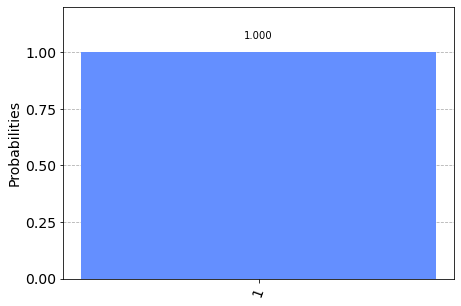

In [59]:
job = execute(qc, backend=simulator, shots=1000)
count = job.result().get_counts(qc)
plot_histogram(count)

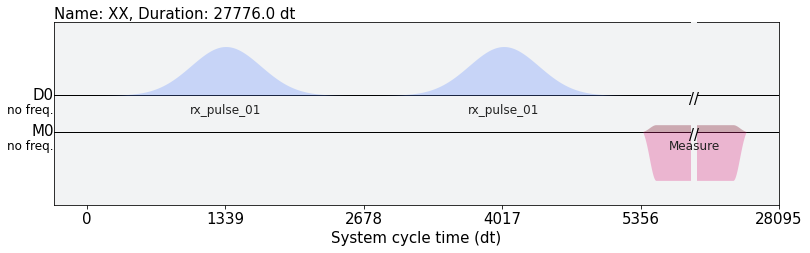

In [54]:
pi = np.pi
def rx_pulse_01(theta):
    rxpulse01 = pulse_lib.gaussian(duration=drive_samples,
                                     amp=pi_amp_01*np.sin(theta/2)**2, 
                                     sigma=drive_sigma,
                                     name='rx_pulse_01')
    return rxpulse01

'''with pulse.build(backend, name='XX') as XX:
    with pulse.align_sequential():
        #pulse.set_frequency(f01, drive_chan)
        pulse.play(rx_pulse_01(pi/2), drive_chan)
        pulse.play(rx_pulse_01(pi/2), drive_chan)
        pulse.call(measure)'''

'''with pulse.build(backend, name='XZX') as XZX:
    with pulse.align_sequential():
        #pulse.set_frequency(f01, drive_chan)
        pulse.play(rx_pulse_01(pi/2), drive_chan)
        pulse.shift_phase(np.pi/4, drive_chan)
        pulse.play(rx_pulse_01(pi/2), drive_chan)
        pulse.call(measure)'''

XX = pulse.Schedule(name="XX")
XX |= pulse.Play(rx_pulse_01(pi/2), drive_chan)
XX |= pulse.Play(rx_pulse_01(pi/2), drive_chan) << XX.duration
XX |= measure << XX.duration

XZX = pulse.Schedule(name="XZX")
XZX |= pulse.Play(rx_pulse_01(pi/2), drive_chan)
XZX |= pulse.ShiftPhase(pi/2, drive_chan) << XZX.duration
#XZX |= pulse.Call(inst_sched_map.get('rz', qubit, np.pi/2)) << XZX.duration
XZX |= pulse.Play(rx_pulse_01(pi/2), drive_chan) << XZX.duration
XZX |= measure << XZX.duration

'''XX = pulse.Schedule(name="XX")
XX |= pulse.ShiftPhase(pi/2, drive_chan)
XX |= pulse.Play(pi_pulse_01, drive_chan) << XX.duration
XX |= pulse.ShiftPhase(-(pi-pi/4), drive_chan) << XX.duration
XX |= pulse.Play(pi_pulse_01, drive_chan) << XX.duration
XX |= pulse.ShiftPhase(pi/2, drive_chan) << XX.duration

XX |= pulse.ShiftPhase(pi/2, drive_chan) << XX.duration
XX |= pulse.Play(pi_pulse_01, drive_chan) << XX.duration
XX |= pulse.ShiftPhase(-(pi-pi/4), drive_chan) << XX.duration
XX |= pulse.Play(pi_pulse_01, drive_chan) << XX.duration
XX |= pulse.ShiftPhase(pi/2, drive_chan) << XX.duration
XX |= measure << XX.duration

XZX = pulse.Schedule(name="XZX")
XZX |= pulse.ShiftPhase(pi/2, drive_chan)
XZX |= pulse.Play(pi_pulse_01, drive_chan) << XZX.duration
XZX |= pulse.ShiftPhase(-(pi-pi/4), drive_chan) << XZX.duration
XZX |= pulse.Play(pi_pulse_01, drive_chan) << XZX.duration
XZX |= pulse.ShiftPhase(pi/2, drive_chan) << XZX.duration

XZX |= pulse.ShiftPhase(pi/4, drive_chan) << XZX.duration

XZX |= pulse.ShiftPhase(pi/2, drive_chan) << XZX.duration
XZX |= pulse.Play(pi_pulse_01, drive_chan) << XZX.duration
XZX |= pulse.ShiftPhase(-(pi-pi/4), drive_chan) << XZX.duration
XZX |= pulse.Play(pi_pulse_01, drive_chan) << XZX.duration
XZX |= pulse.ShiftPhase(pi/2, drive_chan) << XZX.duration
XZX |= measure << XZX.duration'''

XX.draw()

In [55]:
test_program = assemble([XX, XZX],
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=NUM_SHOTS,
                           schedule_los=[{drive_chan: cal_qubit_freq}] * 2)

test_job = backend.run(test_program)
test_count = test_job.result().get_counts()
test_count

/home/doki/miniconda3/envs/myqis/lib/python3.8/site-packages/qiskit/test/mock/fake_backend.py:127: DeprecationWarning: Passing `system_model` as a positional argument to `PulseSimulator.run` has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Pass `system_model` as a kwarg `system_model=model` instead.
  job = sim.run(qobj, system_model)


[{'0': 3.6658187607e-05, '1': 0.999963341812003, '2': 3.9e-13},
 {'0': 0.498618344291018, '1': 0.501381655708317, '2': 6.65e-13}]

# Find Rz_12. Haven't found yet

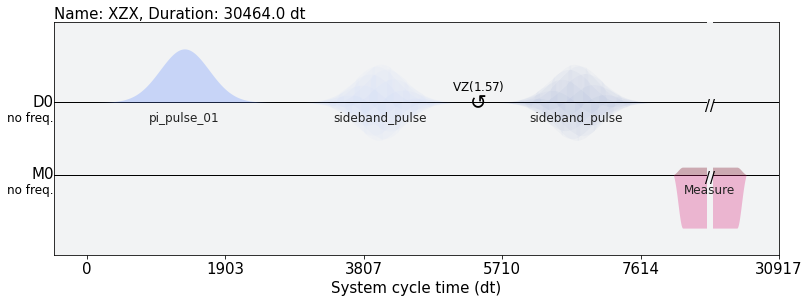

In [56]:
def rx_pulse_12(theta):
    rxpulse12 = pulse_lib.gaussian(duration=drive_samples,
                                     amp=pi_amp_12*np.sin(theta/2)**2, 
                                     sigma=drive_sigma,
                                     name='rx_pulse_12')
    
    rxpulse_12 = apply_sideband(rxpulse12, qubit_12_freq)
    return rxpulse_12

XX2 = pulse.Schedule(name="XX2")
XX2 |= pulse.Play(pi_pulse_01, drive_chan)
XX2 |= pulse.Play(rx_pulse_12(pi/2), drive_chan) << XX2.duration
XX2 |= pulse.Play(rx_pulse_12(pi/2), drive_chan) << XX2.duration
XX2 |= measure << XX2.duration

XZX2 = pulse.Schedule(name="XZX")
XZX2 |= pulse.Play(pi_pulse_01, drive_chan)
XZX2 |= pulse.Play(rx_pulse_12(pi/2), drive_chan) << XZX2.duration
#XZX2 |= pulse.ShiftPhase(pi/2, drive_chan) << XZX2.duration
XZX2 |= pulse.Call(inst_sched_map.get('rz', qubit, np.pi/2)) << XZX2.duration
XZX2 |= pulse.Play(rx_pulse_12(pi/2), drive_chan) << XZX2.duration
XZX2 |= measure << XZX2.duration

XZX2.draw()

In [57]:
test_program2 = assemble([XX2, XZX2],
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=NUM_SHOTS,
                           schedule_los=[{drive_chan: cal_qubit_freq}] * 2)

test_job2 = backend.run(test_program2)
test_count2 = test_job2.result().get_counts()
test_count2

/home/doki/miniconda3/envs/myqis/lib/python3.8/site-packages/qiskit/test/mock/fake_backend.py:127: DeprecationWarning: Passing `system_model` as a positional argument to `PulseSimulator.run` has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Pass `system_model` as a kwarg `system_model=model` instead.
  job = sim.run(qobj, system_model)


[{'0': 4.5003873878e-05, '1': 0.867745861269166, '2': 0.132209134856955},
 {'0': 4.5272985519e-05, '1': 0.161315873865613, '2': 0.838638853148868}]